# Project 1 -  Text Classification Task

## 1 - Data Provenance and Characteristics

The dataset we will be working with consists of publications sourced from Reddit and Google, authored by individuals from England, Australia, and India. 

The Reddit-sourced data is divided as follows:

- Reddit (England): Training data and test data
- Reddit (Australia): Training data and test data
- Reddit (India): Training data and test data

Similarly, an equivalent division applies to the Google-sourced data:

- Google (England): Training data and test data
- Google (Australia): Training data and test data
- Google (India): Training data and test data

All datasets share the same attributes: `id`, a unique identifier for each entry, `text`, the content of the publication, and `sentiment_label`, the target variable for our analysis. The `sentiment_label` is binary, where `0` indicates a negative sentiment and `1` indicates a positive sentiment.

## 2 - Exploratory Data Analysis

### 2.1 - Initial Setup

We begin by reading all 12 datasets. Since the distinction between training and test data is not relevant for our analysis, we first merge them, reducing the total to 6 datasets.

To further facilitate analysis, we also create 3 additional datasets, grouping the data by country of origin. In this step, we combine Reddit and Google data while keeping separate datasets for England, Australia, and India Moreover, we also create 3 datasets, grouping the data by their source, this is Reddit or Google.

In the end, we also created a global dataset, that is, with all the data we have available.

In addition, we remove the `id` attribute at the beginning of our process. This decision was made to prevent inconsistencies, as some publications shared the same `id` across different datasets. Keeping this attribute could lead to ambiguity in the data.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
import re
import os
import time
import gensim
import numpy as np
import math
import contractions
import string

from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.model_selection import train_test_split, GridSearchCV, ParameterGrid
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, classification_report

from wordcloud import WordCloud
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

# import spacy
# nlp = spacy.load("en_core_web_sm")
from scipy import stats

In [2]:
# read Reddit-sourced data 
reddit_uk_train = pd.read_json("data/reddit-uk-train.jsonl", lines=True).drop("id", axis=1)
reddit_in_train = pd.read_json("data/reddit-in-train.jsonl", lines=True).drop("id", axis=1)
reddit_au_train = pd.read_json("data/reddit-au-train.jsonl", lines=True).drop("id", axis=1)
reddit_uk_valid = pd.read_json("data/reddit-uk-valid.jsonl", lines=True).drop("id", axis=1)
reddit_in_valid = pd.read_json("data/reddit-in-valid.jsonl", lines=True).drop("id", axis=1)
reddit_au_valid = pd.read_json("data/reddit-au-valid.jsonl", lines=True).drop("id", axis=1)

# read Google-sourced data 
google_uk_train = pd.read_json("data/google-uk-train.jsonl", lines=True).drop("id", axis=1)
google_in_train = pd.read_json("data/google-in-train.jsonl", lines=True).drop("id", axis=1)
google_au_train = pd.read_json("data/google-au-train.jsonl", lines=True).drop("id", axis=1)
google_uk_valid = pd.read_json("data/google-uk-valid.jsonl", lines=True).drop("id", axis=1)
google_in_valid = pd.read_json("data/google-in-valid.jsonl", lines=True).drop("id", axis=1)
google_au_valid = pd.read_json("data/google-au-valid.jsonl", lines=True).drop("id", axis=1)

# merge Reddit-sourced data by country
reddit_uk_union = pd.concat([reddit_uk_train, reddit_uk_valid], ignore_index=True)
reddit_au_union = pd.concat([reddit_au_train, reddit_au_valid], ignore_index=True)
reddit_in_union = pd.concat([reddit_in_train, reddit_in_valid], ignore_index=True)

# merge Google-sourced data by country
google_uk_union = pd.concat([google_uk_train, google_uk_valid], ignore_index=True)
google_au_union = pd.concat([google_au_train, google_au_valid], ignore_index=True)
google_in_union = pd.concat([google_in_train, google_in_valid], ignore_index=True)

# merge data by country
uk_union = pd.concat([reddit_uk_union, google_uk_union], ignore_index=True)
au_union = pd.concat([reddit_au_union, google_au_union], ignore_index=True)
in_union = pd.concat([reddit_in_union, google_in_union], ignore_index=True)

# merge data by source
reddit_union = pd.concat([reddit_uk_union, reddit_au_union, reddit_in_union], ignore_index=True)
google_union = pd.concat([google_uk_union, google_au_union, google_in_union], ignore_index=True)

# merge all data
global_union = pd.concat([reddit_union, google_union])
test_global = global_union.copy()

In [3]:
def plot_pie_chart(values, labels, title="Pie Chart"):
    plt.figure(figsize=(2 * len(values), len(values)))
    plt.pie(values, labels=labels, autopct='%1.1f%%', startangle=90)   
    plt.title(title)    
    plt.show()

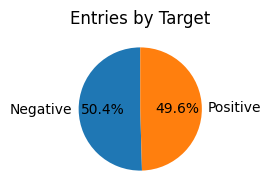

In [4]:
plot_pie_chart([len(global_union[global_union["sentiment_label"] == 0]), len(global_union[global_union["sentiment_label"] == 1])], ["Negative", "Positive"], title="Entries by Target")

### 2.2 - Class Distribution by Source

We begin by comparing the number of entries from Reddit and Google. Our analysis shows that both sources contain approximately the same number of entries.

Next, we analyzed the distribution of the sentiment class in both sources. This analysis reveals that Reddit data is predominantly negative, while Google data is mostly positive.

From Reddit there are 5064
From Google there are 5014


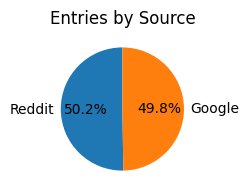

In [5]:
print("From Reddit there are " + str(len(reddit_union)))
print("From Google there are " + str(len(google_union)))
plot_pie_chart([len(reddit_union), len(google_union)], ["Reddit", "Google"], title="Entries by Source")

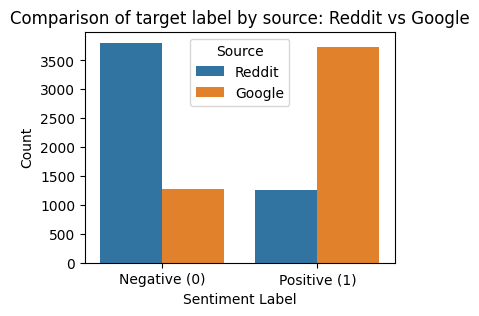

In [6]:
# count distribuition of the target class by source
reddit_counts = reddit_union["sentiment_label"].value_counts().reset_index()
google_counts = google_union["sentiment_label"].value_counts().reset_index()

# create dataframe
reddit_counts.columns = ["sentiment_label", "Reddit"]
google_counts.columns = ["sentiment_label", "Google"]
df = pd.merge(reddit_counts, google_counts, on="sentiment_label", how="outer")
df_melted = df.melt(id_vars="sentiment_label", var_name="Source", value_name="Count")

# create graph
plt.figure(figsize=(4,3))
sns.barplot(data=df_melted, x="sentiment_label", y="Count", hue="Source", palette=["#1f77b4", "#ff7f0e"])
plt.xlabel("Sentiment Label")
plt.ylabel("Count")
plt.title("Comparison of target label by source: Reddit vs Google")
plt.xticks(ticks=[0, 1], labels=["Negative (0)", "Positive (1)"])
plt.legend(title="Source")
plt.show()

### 2.3 - Class Distribution by Country

Similarly to the source analysis, we also examined the distribution of the data across countries, as well as the balance of the target class distribution.

As shown below, the datasets have roughly the same number of entries, and the target class is approximately evenly distributed.

From UK there are 3210
From AU there are 3080
From IN there are 3788


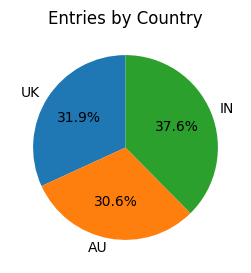

In [7]:
print("From UK there are " + str(len(uk_union)))
print("From AU there are " + str(len(au_union)))
print("From IN there are " + str(len(in_union)))
plot_pie_chart([len(uk_union), len(au_union), len(in_union)], ["UK", "AU", "IN"], title="Entries by Country")


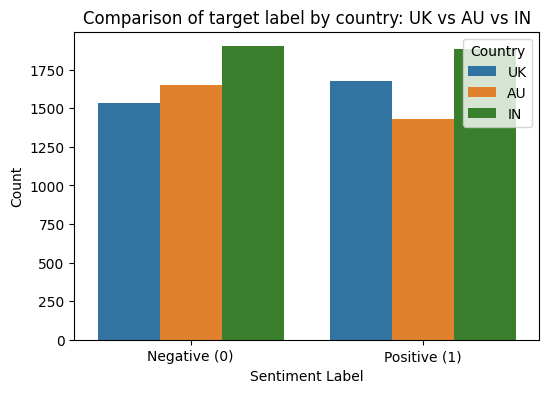

In [8]:
# count distribuition of the target class by country
uk_counts = uk_union["sentiment_label"].value_counts().reset_index()
au_counts = au_union["sentiment_label"].value_counts().reset_index()
in_counts = in_union["sentiment_label"].value_counts().reset_index()

# create dataframe
uk_counts.columns = ["sentiment_label", "UK"]
au_counts.columns = ["sentiment_label", "AU"]
in_counts.columns = ["sentiment_label", "IN"]
df_counts = pd.merge(uk_counts, au_counts, on="sentiment_label", how="outer")
df_counts = pd.merge(df_counts, in_counts, on="sentiment_label", how="outer")
df_melted = df_counts.melt(id_vars="sentiment_label", var_name="Country", value_name="Count")

# create graph
plt.figure(figsize=(6,4))
sns.barplot(data=df_melted, x="sentiment_label", y="Count", hue="Country", palette=["#1f77b4", "#ff7f0e", "#2f8c1f"])
plt.xlabel("Sentiment Label")
plt.ylabel("Count")
plt.title("Comparison of target label by country: UK vs AU vs IN")
plt.xticks(ticks=[0, 1], labels=["Negative (0)", "Positive (1)"])
plt.legend(title="Country")
plt.show()

### 2.4 - Word Distribution by Source

Next, we analyze the distribution of words by source, focusing on the top 10 words. As shown, despite the words appearing in different positions across the sources, there are 3 common words. This low number may be due to the topic of the posts, which can be very different between platforms.

In [9]:
# function to calculate and plot TF-IDF
def plot_tfidf(dataset, title):
    
    # get text column
    texts = dataset["text"]  
    
    # start TfidfVectorizer
    vectorizer = TfidfVectorizer(stop_words='english', max_features=100)
    tfidf_matrix = vectorizer.fit_transform(texts)   
    terms = vectorizer.get_feature_names_out()   
    tfidf_df = pd.DataFrame(tfidf_matrix.toarray(), columns=terms)   
    sum_tfidf = tfidf_df.sum(axis=0)   
    sorted_tfidf = sum_tfidf.sort_values(ascending=False)
    
    # plot graph
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(sorted_tfidf)
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
    plt.title(title)
    plt.show()
    
    return sorted_tfidf.head(10).index.tolist()

def plot_wordcolud(dataset):
    wordcloud = WordCloud().generate(" ".join(dataset["text"].dropna().astype(str)))
    plt.figure(figsize=(6, 3))
    plt.imshow(wordcloud)
    plt.axis('off')
    plt.show()

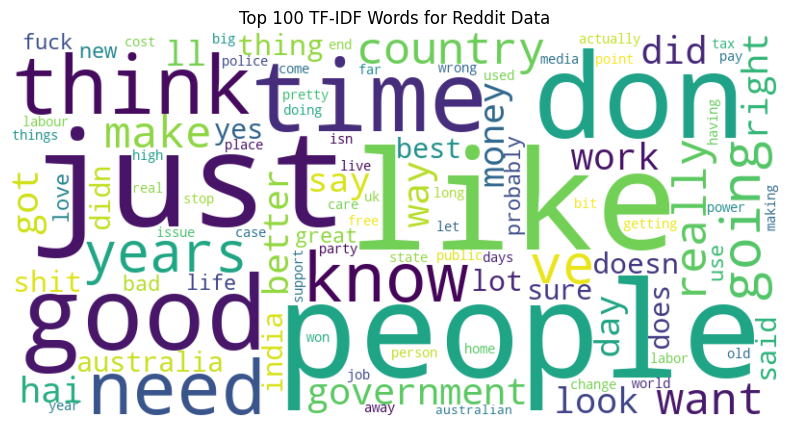

In [10]:
reddit_top = plot_tfidf(reddit_union, 'Top 100 TF-IDF Words for Reddit Data')

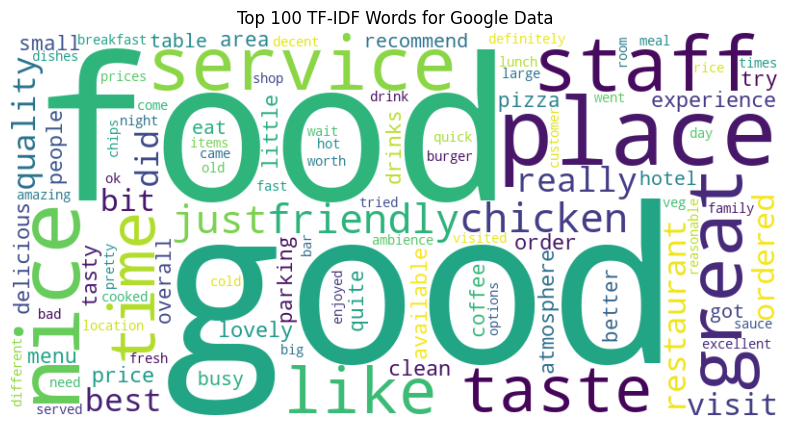

In [11]:
google_top = plot_tfidf(google_union, 'Top 100 TF-IDF Words for Google Data')

In [12]:
comumn_top = list(set(reddit_top) & set(google_top))

print("There are " + str(len(comumn_top)) + " comumn words.")
print("They are : " + str(comumn_top))

There are 3 comumn words.
They are : ['like', 'time', 'good']


### 2.5 - Word Distribution by Country

We also analyzed the distribution of words by country. As shown, the vocabulary does not seem to vary significantly across countries, as the number of common words between two datasets ranges from 7 to 8 out of 10.

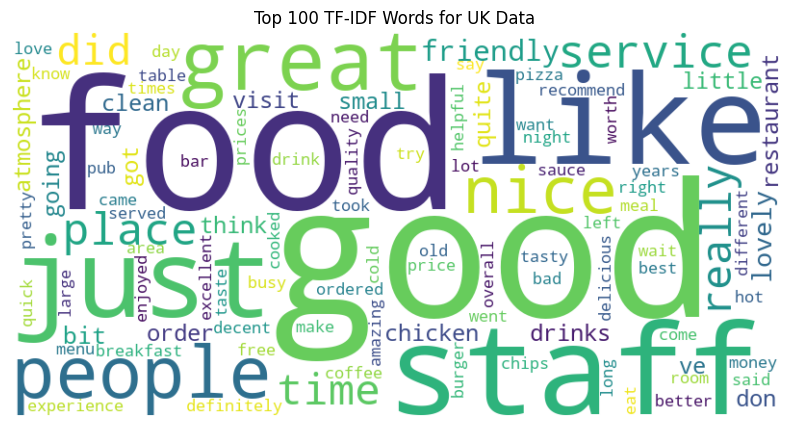

In [13]:
uk_top = plot_tfidf(uk_union, 'Top 100 TF-IDF Words for UK Data')

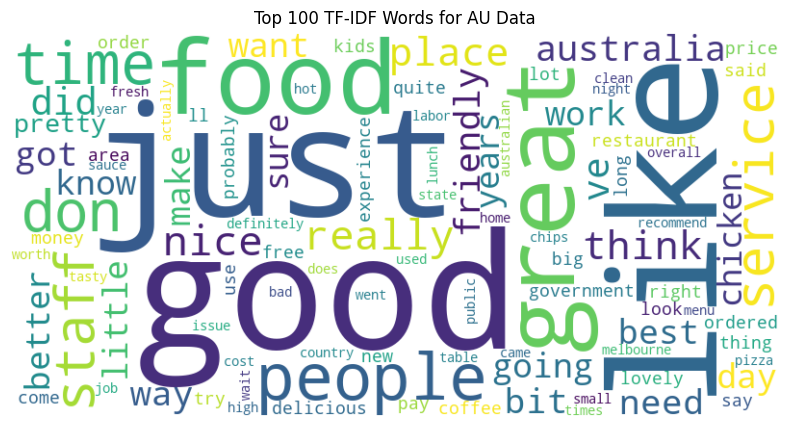

In [14]:
au_top = plot_tfidf(au_union, 'Top 100 TF-IDF Words for AU Data')

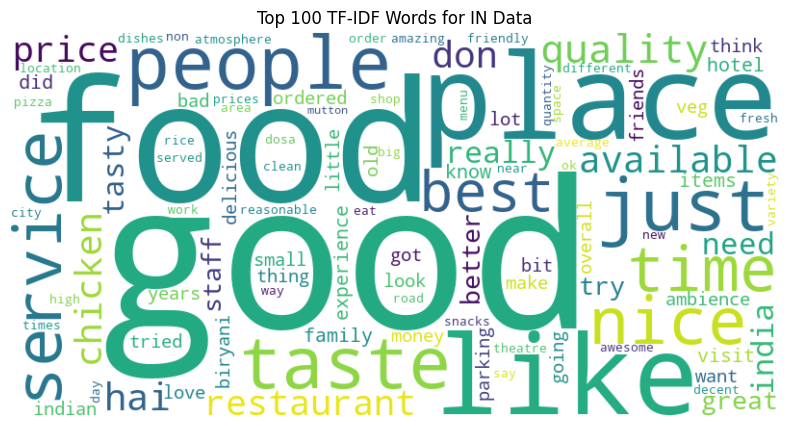

In [15]:
in_top = plot_tfidf(in_union, 'Top 100 TF-IDF Words for IN Data')

In [16]:
comumn_uk_au_top = list(set(uk_top) & set(au_top))
comumn_au_in_top = list(set(au_top) & set(in_top))
comumn_in_uk_top = list(set(in_top) & set(uk_top))

print("UK and AU")
print("There are " + str(len(comumn_uk_au_top)) + " comumn words.")
print("They are : " + str(comumn_uk_au_top))

print("\nAU and IN")
print("There are " + str(len(comumn_au_in_top)) + " comumn words.")
print("They are : " + str(comumn_au_in_top))

print("\nIN and UK")
print("There are " + str(len(comumn_in_uk_top)) + " comumn words.")
print("They are : " + str(comumn_in_uk_top))

UK and AU
There are 8 comumn words.
They are : ['service', 'staff', 'good', 'food', 'great', 'people', 'like', 'just']

AU and IN
There are 7 comumn words.
They are : ['service', 'good', 'just', 'food', 'people', 'like', 'time']

IN and UK
There are 8 comumn words.
They are : ['service', 'nice', 'good', 'place', 'food', 'people', 'like', 'just']


## 3 - Data Pre-Processing

In this step, we remove all characters that are not alphabetical or whitespace. Additionally, we convert the text to lowercase and eliminate consecutive spaces. After cleaning the text, we perform tokenization and lemmazation. Finally, we remove words from the stopwords list, except for those with negation, as they are crucial for our classification task.

We initially experimented with stemming as an alternative to lemmatization but ultimately chose the latter. At first, our lemmatization approach did not account for a word’s context, leading to incorrect results. Upon further investigation, we discovered the importance of specifying the "pos" parameter in the "lemmatize" function, which determines whether a word is a verb, noun, adjective, or adverb. To ensure accurate classification, we leveraged the "pos_tag" function from NLTK to assign the appropriate part of speech before lemmatization.

In [17]:
stop_words = set(nltk.corpus.stopwords.words('english'))
stop_words_remove = {"no", "not", "nor", "t"}
stop_words.difference_update(stop_words_remove)

lemma = nltk.WordNetLemmatizer()
token = nltk.word_tokenize

def lemmatize_with_pos(text):
    words = token(text)   
    words_tag = nltk.pos_tag(words)   
    words_lem = []
    for word, tag in words_tag:
        if tag.startswith('N'): words_lem.append(lemma.lemmatize(word, pos='n')) # noun
        elif tag.startswith('V'): words_lem.append(lemma.lemmatize(word, pos='v')) # verb
        elif tag.startswith('J'): words_lem.append(lemma.lemmatize(word, pos='a')) # adjective
        elif tag.startswith('R'): words_lem.append(lemma.lemmatize(word, pos='r')) # adverb
        else: words_lem.append(lemma.lemmatize(word))
    return words_lem

def text_pre_processing(dataset):
    # text_vader
    dataset['text_vader'] = dataset['text'].apply(contractions.fix)
    dataset['text_vader'] = dataset["text_vader"].apply(lambda x: re.sub(r'[^\x00-\x7F]|[^a-zA-Z ]', ' ', x).strip()) # remove all the caracteres that do not belong to the alphabet and are not a whitespace
    dataset["text_vader"] = dataset["text_vader"].apply(str.lower) # converte all caracteres to lowercase
    dataset["text_vader"] = dataset["text_vader"].apply(lambda x: re.sub(r'\s+', ' ', x).strip()) # remove multiple whitespaces  
    # text_processed
    dataset['text_processed'] = dataset['text_vader'].apply(token) # apply tokenization    
    dataset['text_processed'] = dataset['text_processed'].apply(lambda x: [word for word in x if word not in stop_words]) # remove stopwords, mantaining words like 'no', 'not', 'nor', 't'
    # # # apply stemization
    # # dataset['text_processed'] = dataset['text_processed'].apply(lambda x: [nltk.PorterStemmer().stem(w) for w in x])    
    dataset['text_processed'] = dataset['text_processed'].apply(lambda x: lemmatize_with_pos(" ".join(x))) # apply lemmazation   
    dataset['text_processed'] = [" ".join(text) for text in dataset["text_processed"]] # join words from the list in a sentence    
    return dataset
       
def metrics(y_test, y_pred, time):
    [[tp, fp], [fn, tn]] = (confusion_matrix(y_test, y_pred))
    print("                    predicted positive   predicted negative")
    print("real positive       " + str(tp) + (" " * (len(str(fp)) - 1)) + "                " + str(fn))
    print("real negative       " + str(fp) + (" " * (len(str(tp)) - 1)) + "                " + str(tn))
    print(f"\nAccuracy {accuracy_score(y_test, y_pred):.2f} Precision {precision_score(y_test, y_pred):.2f} Recall {recall_score(y_test, y_pred):.2f} F1 Score {f1_score(y_test, y_pred):.2f} Time {time:.2f}") 

text_pre_processing(global_union)

,text,sentiment_label,text_vader,text_processed
0,"So instead of making savings, they continued t...",0,so instead of making savings they continued to...,instead make saving continue spend money not y...
1,Needless story to have dragged into the electi...,0,needless story to have dragged into the electi...,needless story drag election party rumour sat ...
2,"Now, in an ideal world there would be insight ...",0,now in an ideal world there would be insight i...,ideal world would insight mr james daly think ...
3,How did you not get mind controlled at birth t...,0,how did you not get mind controlled at birth t...,not get mind control birth though one free thi...
4,"Talk lately of conscription, having a store of...",0,talk lately of conscription having a store of ...,talk lately conscription store food water drug...
...,...,...,...,...
5009,It was ok. Chef need to bring taste in food. J...,0,it was ok chef need to bring taste in food jus...,ok chef need bring taste food ok type restaura...
5010,Food is best for middle class people here. All...,1,food is best for middle class people here all ...,food best middle class people item give quanti...
5011,I think cinema hall is better and full air con...,1,i think cinema hall is better and full air con...,think cinema hall well full air condition soun...
5012,The cafe looks good and we can celebrate birth...,1,the cafe looks good and we can celebrate birth...,cafe look good celebrate birthday food taste a...


After making these modifications, we checked for words that were not recognized in NLTK's vocabulary, which likely indicated spelling errors. We attempted to use libraries like TextBlob to correct these mistakes but ultimately decided against it due to the high processing time.

In [18]:
nltk.download('words')

valid_words = set(nltk.corpus.words.words())
invalid_words = set()
invalid_entries = set()

corpus = global_union["text_processed"].dropna().astype(str).tolist()
for idx, comment in enumerate(corpus):
    words = comment.split()
    for word in words:
        if word not in valid_words:
            invalid_words.add(word)
            invalid_entries.add(idx)

print("There are " + str(len(invalid_entries)) + " entries with invalid words")
print("The words are " + str(invalid_words))

There are 7642 entries with invalid words
The words are {'extracurriculars', 'locatl', 'kathiyawad', 'voh', 'torygraph', 'ottoman', 'clouds', 'tezpur', 'upload', 'dystopia', 'timeout', 'programme', 'wirral', 'sangai', 'deplaneted', 'avalon', 'wrexham', 'tussauds', 'haloumi', 'kasundi', 'yeh', 'filipino', 'translates', 'youtuber', 'questacon', 'varies', 'pw', 'noodles', 'berths', 'valimai', 'kalucha', 'grawin', 'sivakasi', 'airlie', 'bbgdw', 'tbf', 'chhaas', 'biscoffee', 'edinburgh', 'streetchinese', 'germophobic', 'nazis', 'throor', 'isreali', 'chinatown', 'teams', 'verg', 'margerine', 'superiotity', 'warsi', 'triveni', 'monash', 'ciggerate', 'yuckiest', 'throughly', 'timepass', 'tadaka', 'xmas', 'helens', 'centre', 'americanise', 'oecd', 'superfast', 'anandhas', 'rss', 'naina', 'tabahi', 'poricha', 'rohu', 'dipshit', 'kamata', 'gdp', 'monopolise', 'rupert', 'becos', 'ferrari', 'equipped', 'wiki', 'imobile', 'winni', 'buffett', 'portfilters', 'rupees', 'breakwall', 'hashbrown', 'yummm'

[nltk_data] Downloading package words to
[nltk_data]     C:\Users\pisco\AppData\Roaming\nltk_data...
[nltk_data]   Package words is already up-to-date!


We then deleted the entries that had an empty "text_processed" attribute. This could happen due to pre-processing, for example, if the text attribute only consisted of characters that did not belong to the alphabet.

In [19]:
print("Before we had " + str(len(global_union)) + " entries.")
global_union = global_union[global_union["text_processed"].str.len() > 0]
print("Now we have " + str(len(global_union)) + " entries.")

Before we had 10078 entries.
Now we have 10076 entries.


After we have made these modifications to the datasets, we save them to our repository.

In [20]:
folder_path = "data_prepared"
os.makedirs(folder_path, exist_ok=True)
global_union.to_csv(os.path.join(folder_path, "global_union.csv"), index=False, encoding="utf-8")

## 4. Feature Representation Technique
Subsequently, we applied a range of feature representation techniques, exploring both sparse and dense vector approaches.

In relation to sparse vectors:

- **CountVectorizer**: the text is converted into a "bag of words" (BoW), where the order of the words is not considered. The focus is solely on how many times each word appears in the document, without taking into account the sequence or context in which it occurs.

- **TfidfVectorizer**: is similar to CountVectorizer, but with an important difference: it adjusts the word counts by considering not only the frequency of a word in a specific text but also its relative importance in the larger set of documents.

- **ngram_range in TfidfVectorizer**: the `ngram_range` parameter in TfidfVectorizer allows the model to capture n-grams. By setting `ngram_range` to `(1,2)`, the model will consider both unigrams (individual words) and bigrams (pairs of consecutive words), allowing it to capture more contextual information between nearby words.

In relation to dense vectors:

- **Word2Vec**: used to generate dense vector representations of words in a continuous vector space, where words with similar meanings are close together in the vector space.

- **GloVe**: is also a word embedding technique, but unlike Word2Vec, which is based on a predictive model, GloVe is based on word co-occurrence matrices in a corpus. It tries to capture the global relationships between words, making it effective for representing word meanings in broader contexts.

We also utilize **VADER**, implementing two different approaches. The first, a simpler approach, calculates the polarity of each word and classifies it as positive or negative. The second, a more complex approach, is an algorithm inspired by one from the professor's slides, which considers additional factors beyond polarity.

In [21]:
corpus = global_union["text_processed"].dropna().astype(str).tolist()
lens = [len(c.split()) for c in corpus]
print("Text Processed's characteristic:")
print(np.min(lens), np.max(lens), np.mean(lens), np.std(lens), stats.mode(lens))

Text Processed's characteristic:
1 770 26.99404525605399 31.522347005418055 ModeResult(mode=7, count=350)


### 4.1. Sparse Vectors

In [22]:
print("Representation with sparse vectors:\n")

vectorizer = CountVectorizer(stop_words=None)
x_CountVectorizer = vectorizer.fit_transform(corpus)
print("  - CountVectorizer's shape is " + str(x_CountVectorizer.shape))

vectorizer = TfidfVectorizer(stop_words=None)
x_TfidfVectorizer = vectorizer.fit_transform(corpus)
print("  - TfidfVectorizer's shape is " + str(x_TfidfVectorizer.shape))

vectorizer = TfidfVectorizer(stop_words=None, ngram_range=(1,2)) # unigram and bigram
x_TfidfVectorizerUB = vectorizer.fit_transform(corpus)
print("  - TfidfVectorizerUB's shape is" + str(x_TfidfVectorizerUB.shape))

vectorizer = TfidfVectorizer(stop_words=None, ngram_range=(2,2)) # bigram
x_TfidfVectorizerB = vectorizer.fit_transform(corpus)
print("  - TfidfVectorizerB's shape is " + str(x_TfidfVectorizerB.shape))

Representation with sparse vectors:

  - CountVectorizer's shape is (10076, 19683)
  - TfidfVectorizer's shape is (10076, 19683)
  - TfidfVectorizerUB's shape is(10076, 205010)
  - TfidfVectorizerB's shape is (10076, 185327)


### 4.2. Dense Vectors

In [23]:
print("Representation with dense vectors:\n")

def text_to_vector(embeddings, text, sequence_len):
    tokens = text.split()
    vec = []
    n = 0
    i = 0
    while i < len(tokens) and n < sequence_len:
        try:
            vec.extend(embeddings.get_vector(tokens[i]))
            n += 1
        except KeyError: True
        finally: i += 1
    
    for j in range(sequence_len - n):
        vec.extend(np.zeros(embeddings.vector_size,))
        
    return vec

def text_to_vector_glove(embeddings, text, sequence_len, embedding_dim=100):
    tokens = text.split()
    vec = []
    n = 0
    i = 0
    while i < len(tokens) and n < sequence_len:
        if tokens[i] in embeddings:
            vec.extend(embeddings[tokens[i]])
            n += 1
        i += 1
   
    for _ in range(sequence_len - n):
        vec.extend(np.zeros(embedding_dim,))
        
    return vec

temp_corpus = [x.split() for x in corpus]
model = gensim.models.Word2Vec(temp_corpus, vector_size=100, window=3, min_count=2, workers=10, sg=1)
embeddings_corpus = []
for c in corpus:
    embeddings_corpus.append(text_to_vector(model.wv, c, 10))

x_Word2Vec = np.array(embeddings_corpus)
print("  - Word2Vec's shape is " + str(x_Word2Vec.shape))

word_vectors = {}
with open("data_prepared/glove.6B.100d.txt", encoding="utf-8") as f:
    for line in f:
        values = line.split()
        word = values[0]
        vector = np.asarray(values[1:], dtype="float32")
        word_vectors[word] = vector

embeddings_corpus_glove = [text_to_vector_glove(word_vectors, c, 10) for c in corpus]
x_GloVe = np.array(embeddings_corpus_glove)
print("  - GloVe's shape is " + str(x_GloVe.shape))

Representation with dense vectors:

  - Word2Vec's shape is (10076, 1000)
  - GloVe's shape is (10076, 1000)


### 4.3. Vader

In [24]:
sia = SentimentIntensityAnalyzer()
y_pred = []

start_time = time.time()
for comment in global_union['text']:
    y_pred.append(1 if sia.polarity_scores(comment)['compound'] > 0 else 0)
end_time = time.time()

metrics(global_union['sentiment_label'], y_pred, end_time - start_time)

                    predicted positive   predicted negative
real positive       2994                   518
real negative       2090                   4474

Accuracy 0.74 Precision 0.68 Recall 0.90 F1 Score 0.77 Time 1.48


In [25]:
x1_list, x2_list, x3_list, x4_list, x5_list, x6_list = [], [], [], [], [], []
word_info = dict()
pronouns = {"i", "me", "my", "mine", "we", "us", "our", "ours", "you", "your", "yours"}

for line in global_union["text_vader"]:
    words = line.split()
    x1, x2 = 0, 0
    for word in words:
        
        # if word was already checked
        if word in word_info:
            if word_info[word] == 1: x1 += 1
            elif word_info[word] == -1: x2 += 1
            
        # if not calculate polarity and add to the dictionary
        else:
            neg_polarity = sia.polarity_scores(word)["neg"]
            pos_polarity = sia.polarity_scores(word)["pos"]
            cpd_polarity = sia.polarity_scores(word)["compound"]
            if cpd_polarity > 0.05 and pos_polarity > neg_polarity:
                word_info[word] = 1
                x1 += 1
            elif cpd_polarity < -0.05 and pos_polarity < neg_polarity:
                word_info[word] = -1
                x2 += 1
            else:
                word_info[word] = 0
    
    x1_list.append(x1)
    x2_list.append(x2)
    x3_list.append(1 if "no" in words else 0)
    x4_list.append(sum(1 for word in words if word in pronouns))
    x5_list.append(1 if "!" in words else 0)
    x6_list.append(math.log(len(words) + 1))


global_union["x3"] = x3_list # 1 if "no" is present and 0 otherwise
global_union["x4"] = x4_list # number of pronouns
global_union["x5"] = x5_list # 1 if "!" is present and 0 otherwise
global_union["x6"] = x6_list # logarithm of text length for normalization.
global_union["x1"] = x1_list # number of positive words
global_union["x2"] = x2_list # number of negative words
    
x_vader = global_union[["x1", "x2", "x3", "x4", "x5", "x6"]]

C:\Users\pisco\AppData\Local\Temp\ipykernel_11036\2617143817.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  global_union["x3"] = x3_list # 1 if "no" is present and 0 otherwise
C:\Users\pisco\AppData\Local\Temp\ipykernel_11036\2617143817.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  global_union["x4"] = x4_list # number of pronouns
C:\Users\pisco\AppData\Local\Temp\ipykernel_11036\2617143817.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try us

## 5. Algorithms

In [ ]:
parameters = {
    'LogisticRegression': [
        {
            'penalty': ['l2', None],
            'solver': ['lbfgs'],
            'max_iter': [750, 1000, 1250, 1500],
        },
        {
            'penalty': ['l1', 'l2'],
            'solver': ['liblinear'],
            'max_iter': [750, 1000, 1250, 1500],
        },
        {
            'penalty': ['l1', 'l2', None],
            'solver': ['saga'],
            'max_iter': [750, 1000, 1250, 1500],
        },
        {
            'penalty': ['elasticnet'],
            'solver': ['saga'],
            'max_iter': [750, 1000, 1250, 1500],
            'l1_ratio': [0.0, 0.25, 0.5, 0.75, 1.0],
        },
    ],
    'SGDClassifier': [
        {
            'loss': ['hinge', 'modified_huber', 'squared_hinge', 'perceptron'],
            'penalty': ['l1', 'l2', 'elasticnet'],
            'learning_rate': ['constant', 'optimal', 'invscaling'],
        },
        {
            'loss': ['hinge', 'modified_huber', 'squared_hinge', 'perceptron'],
            'penalty': ['elasticnet'],
            'learning_rate': ['constant', 'optimal', 'invscaling'],
            'l1_ratio': [0.0, 0.25, 0.5, 0.75, 1.0],
        },

        {
            'loss': ['log'],
            'penalty': ['l2'],
            'learning_rate': ['constant', 'invscaling'],
        },
        {
            'loss': ['log'],
            'penalty': ['elasticnet'],
            'learning_rate': ['constant', 'invscaling'],
            'l1_ratio': [0.0, 0.25, 0.5, 0.75, 1.0],
        }
    ]
}

#valid_params_log = []
#for params in ParameterGrid(parameters['LogisticRegression']):
#    if params['solver'] == 'lbfgs' and params['penalty'] in ['l1', 'elasticnet']:
#        continue
#    if params['solver'] == 'liblinear' and params['penalty'] in [None, 'elasticnet']:
#        continue
#    if params['l1_ratio'] != None and params['penalty'] in ['l1', 'l2', None]:
#        continue
#
#    if params['l1_ratio'] == None and params['penalty'] in ['elasticnet']:
#        continue
#    params['penalty'] = [params['penalty'] ]
#    params['solver'] = [params['solver'] ]
#    params['max_iter'] = [params['max_iter'] ]
#    params['l1_ratio'] = [params['l1_ratio']]
#    valid_params_log.append(params)
#
#valid_params_sgd = list(ParameterGrid(parameters['SGDClassifier']))
#valid_parameters = {'LogisticRegression': valid_params_log, 'SGDClassifier': valid_params_sgd}

def parameter_tuning(clf, x_predict, y_predict):
    grid_search = GridSearchCV(clf, parameters[str(clf.__class__.__name__)], cv=5, n_jobs=-1, verbose=1)
    grid_search.fit(x_predict, y_predict)
    return grid_search.best_estimator_, grid_search.best_params_
    

def predict_nb(x, y):
    # split dataset and define classifier
    X_train, X_test, y_train, y_test = train_test_split(x, y, test_size = 0.20, random_state=42)
    clf = MultinomialNB()
    # training
    start_time = time.time()
    clf.fit(X_train, y_train)
    end_time = time.time()
    # testing
    y_pred = clf.predict(X_test)
    metrics(y_test, y_pred, end_time - start_time)
    return y_pred

def predict_log(x, y):
    # split dataset and define classifier
    X_train, X_test, y_train, y_test = train_test_split(x, y, test_size = 0.20, random_state=42)
    clf = LogisticRegression(max_iter=1000)
    # parameter tunning and training 
    model, param = parameter_tuning(clf, X_train, y_train)
    start_time = time.time()   
    model.fit(X_train, y_train)
    end_time = time.time()
    # testing
    print(f"\nBets parameters: {param}")
    y_pred = model.predict(X_test)
    metrics(y_test, y_pred, end_time - start_time)
    return y_pred
    
def predict_sgd(x, y):
    # split dataset and define classifier
    X_train, X_test, y_train, y_test = train_test_split(x, y, test_size = 0.20, random_state=42)
    clf = SGDClassifier(max_iter=1000, tol=1e-3)
    # parameter tunning and training 
    model, param = parameter_tuning(clf, X_train, y_train)
    start_time = time.time()   
    model.fit(X_train, y_train)
    end_time = time.time()
    # testing
    print(f"\nBets parameters: {param}")
    y_pred = model.predict(X_test)
    metrics(y_test, y_pred, end_time - start_time)
    return y_pred

### 5.1 Baseline

Initially, we developed a baseline model where the text was not subjected to any preprocessing, and the feature representation was based on a Bag of Words approach. For classification, we utilized the Multinomial Naive Bayes (MultinomialNB) algorithm.

Comparing the size of the feature space in our baseline model, which utilizes raw text without any preprocessing, we observe that it is significantly larger than the feature space of the preprocessed text. Specifically, the baseline model results in **28,874 features**, whereas the preprocessed text yields **16,551 features**, making the feature space approximately **1.7 times larger** in the absence of preprocessing.

In [27]:
vectorizer = CountVectorizer(stop_words=None, lowercase=False, binary=True)
x_baseline = vectorizer.fit_transform(global_union['text'].dropna().astype(str).tolist())
print("Baseline - " + str(x_baseline.shape))
predict_nb(x_baseline, global_union['sentiment_label'])

Baseline - (10076, 29458)
                    predicted positive   predicted negative
real positive       809                  171
real negative       212                  824

Accuracy 0.81 Precision 0.80 Recall 0.83 F1 Score 0.81 Time 0.00


array([1, 0, 0, ..., 1, 1, 1], dtype=int64)

### 5.2. Multinomial Naive Bayes

Comparing the results obtained with the preprocessed text to those of the baseline model, we observe that the differences in error rates are minimal. However, the models using preprocessed text demonstrate **substantially faster training times**.

We can also observe that, regarding the use of n-grams, the model utilizing only bigrams yields the poorest results. In contrast, the model that combines unigrams and bigrams achieves better performance. This approach strikes a good balance, potentially improving the model's ability to handle cases involving negation more effectively.

In [28]:
# sparse representations
predict_nb(x_CountVectorizer, global_union['sentiment_label'])
predict_nb(x_TfidfVectorizer, global_union['sentiment_label'])
predict_nb(x_TfidfVectorizerUB, global_union['sentiment_label'])
predict_nb(x_TfidfVectorizerB, global_union['sentiment_label'])

                    predicted positive   predicted negative
real positive       808                  164
real negative       213                  831

Accuracy 0.81 Precision 0.80 Recall 0.84 F1 Score 0.82 Time 0.00
                    predicted positive   predicted negative
real positive       791                  154
real negative       230                  841

Accuracy 0.81 Precision 0.79 Recall 0.85 F1 Score 0.81 Time 0.00
                    predicted positive   predicted negative
real positive       800                  160
real negative       221                  835

Accuracy 0.81 Precision 0.79 Recall 0.84 F1 Score 0.81 Time 0.03
                    predicted positive   predicted negative
real positive       809                  217
real negative       212                  778

Accuracy 0.79 Precision 0.79 Recall 0.78 F1 Score 0.78 Time 0.01


array([1, 0, 0, ..., 1, 1, 1], dtype=int64)

### 5.3. Logistic Regression

Based on the results obtained previously, we decided to discontinue testing models with features extracted using TfidfVectorizer and bigrams. In addition, we explored feature representations using dense vectors, generated through two different methods: **Word2Vec** and **GloVe**.  

When comparing Logistic Regression with Multinomial Naive Bayes, we observed that Logistic Regression consistently outperforms Naive Bayes in terms of accuracy. However, it requires a longer training time due to its iterative optimization process. In contrast, Naive Bayes is significantly faster, but its performance is generally inferior.  

Additionally, we found that models trained with sparse vector representations tend to yield better results than those using dense vector representations. Notably, Word2Vec-based features performed significantly worse, which may be attributed to the limited size of our dataset and vocabulary. This likely prevented the Word2Vec model from effectively capturing the semantic relationships between words, resulting in poorer feature representations.

In [ ]:
# sparse representations
predict_log(x_CountVectorizer, global_union['sentiment_label'])
predict_log(x_TfidfVectorizer, global_union['sentiment_label'])
predict_log(x_TfidfVectorizerUB, global_union['sentiment_label'])
# dense representations
predict_log(x_Word2Vec, global_union['sentiment_label'])
predict_log(x_GloVe, global_union['sentiment_label'])
# vader representation
predict_log(x_vader, global_union['sentiment_label'])

Fitting 5 folds for each of 96 candidates, totalling 480 fits


c:\Users\pisco\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\pisco\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(



Bets parameters: {'l1_ratio': 0.0, 'max_iter': 750, 'penalty': 'elasticnet', 'solver': 'saga'}
                    predicted positive   predicted negative
real positive       874                  195
real negative       147                  800

Accuracy 0.83 Precision 0.84 Recall 0.80 F1 Score 0.82 Time 1.27
Fitting 5 folds for each of 96 candidates, totalling 480 fits


c:\Users\pisco\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_logistic.py:1197: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
c:\Users\pisco\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_logistic.py:1197: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(



Bets parameters: {'l1_ratio': 0.5, 'max_iter': 750, 'penalty': 'l2', 'solver': 'saga'}
                    predicted positive   predicted negative
real positive       905                  201
real negative       116                  794

Accuracy 0.84 Precision 0.87 Recall 0.80 F1 Score 0.83 Time 0.07
Fitting 5 folds for each of 96 candidates, totalling 480 fits


### 5.3. Stochastic Gradient Descent (SGD) Classifier

In [ ]:
# sparse representations
predict_sgd(x_CountVectorizer, global_union['sentiment_label'])
predict_sgd(x_TfidfVectorizer, global_union['sentiment_label'])
predict_sgd(x_TfidfVectorizerUB, global_union['sentiment_label'])
# dense representations
predict_sgd(x_Word2Vec, global_union['sentiment_label'])
predict_sgd(x_GloVe, global_union['sentiment_label'])
# vader representation
predict_sgd(x_vader, global_union['sentiment_label'])